In [16]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import pandas as pd
import seaborn as sns
import glob
import os
import re
from scipy.signal import savgol_filter
import seaborn as sns
from skimage.measure import profile_line
import matplotlib.patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar

def rastersstats_to_dict(dir):

    rstr_dict = {}
    file_list = glob.glob(str(dir) + '*.tif')

    for f in file_list:

        rstr_dict[f] = {}
        src = rasterio.open(f)
        rstr_dict[f]['arr'] = src.read(1)
        rstr_dict[f]['mu'] = np.nanmean(rstr_dict[f]['arr'])
        rstr_dict[f]['sigma'] = np.nanstd(rstr_dict[f]['arr'])
        rstr_dict[f]['CV'] = rstr_dict[f]['sigma'] / rstr_dict[f]['mu']
        rstr_dict[f]['year'] = re.findall('(\d{4})', f)

    return rstr_dict

In [2]:
d1 = rastersstats_to_dict('../../gis/raster/hv/snow_depth/corrected/wt_and_lake/')
d2 = rastersstats_to_dict('../../fidelity_analysis/results/hv_wt_and_lake/2012_v._2016/')
d = {**d1, **d2}
print(d.keys())

dict_keys(['../../gis/raster/hv/snow_depth/corrected/wt_and_lake/hv_wt_and_lake_depth_2012.tif', '../../gis/raster/hv/snow_depth/corrected/wt_and_lake/hv_wt_and_lake_depth_2016.tif', '../../fidelity_analysis/results/hv_wt_and_lake/2012_v._2016/2012_v._2016_cwssim_arr.tif', '../../fidelity_analysis/results/hv_wt_and_lake/2012_v._2016/2012_v._2016_nrmse_arr.tif', '../../fidelity_analysis/results/hv_wt_and_lake/2012_v._2016/2012_v._2016_gms_arr.tif', '../../fidelity_analysis/results/hv_wt_and_lake/2012_v._2016/2012_v._2016_ssim_arr.tif'])


In [3]:
sub = {}

interesting_keys = ['2012', '2016','ssim','nrmse','cwssim', 'gms']
for k in interesting_keys:
    for dk in d.keys():
        if k in dk:
            sub[dk.split('/')[-1][:-4]]=d[dk]           
desired_order_list = ['hv_wt_and_lake_depth_2012',
                      'hv_wt_and_lake_depth_2016',
                      '2012_v._2016_nrmse_arr',
                      '2012_v._2016_ssim_arr',
                      '2012_v._2016_gms_arr',
                      '2012_v._2016_cwssim_arr']
reordered_dict = {k: sub[k] for k in desired_order_list}
sub = reordered_dict.copy()

In [4]:
# try normalizing again...

x = sub['2012_v._2016_nrmse_arr']['arr']
normalized = (x-x.min())/(x.max()-x.min())
sub['2012_v._2016_nrmse_arr']['arr'] = normalized

In [10]:
sub['hv_wt_and_lake_depth_2012']['arr'] = np.where(sub['hv_wt_and_lake_depth_2012']['arr'] == -9999, 0, sub['hv_wt_and_lake_depth_2012']['arr'])

In [11]:
print(sub['hv_wt_and_lake_depth_2012']['arr'].shape)

(640, 580)


In [12]:
src = (420, 10)
dst = (420, 570)

titles = ['2012 Depth (m)','2016 Depth (m)','NRMSE',
          '','','',
          'SSIM','GMS','CW-SSIM',
          '','','']
arrs = []
transect_data = [0,0,0]

i = 0

for k in sub.keys():

    arrs.append(sub[k]['arr'])
    x = profile_line(sub[k]['arr'], src, dst)
    transect_data.append(x)

    if i == 2:
        arrs.append(0)
        arrs.append(0)
        arrs.append(0)
        transect_data.append(0)
        transect_data.append(0)
        transect_data.append(0)

    sub[k]['title']=titles[i]
    
    i+=1
arrs.append(0)
arrs.append(0)
arrs.append(0)

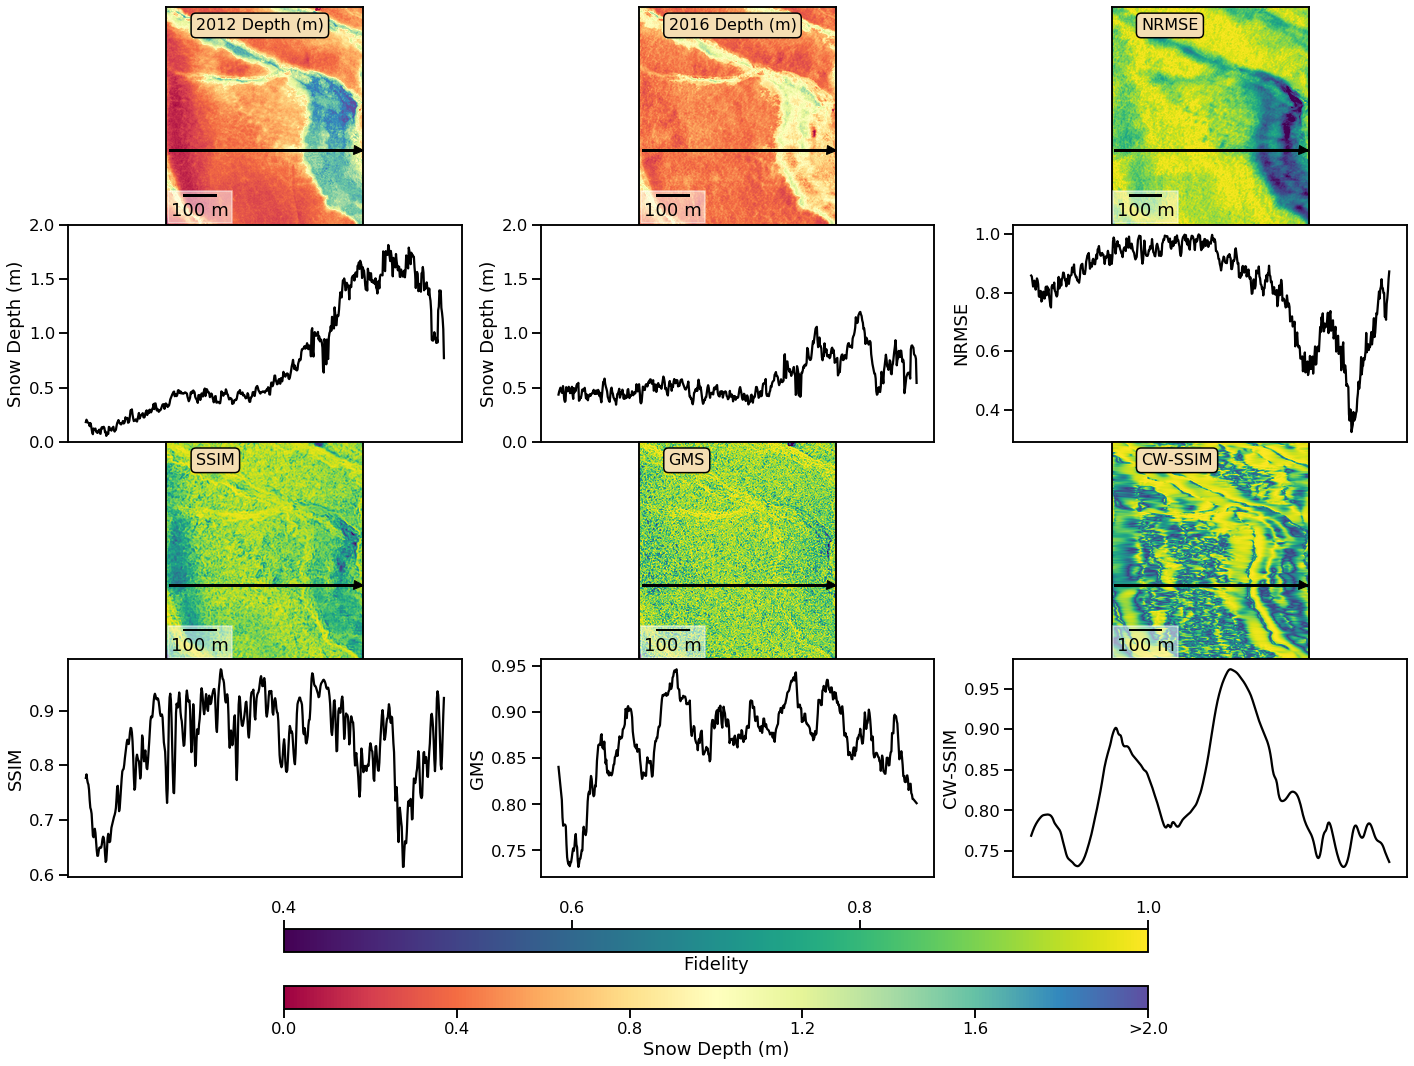

In [25]:
sns.set_context('talk')

f, axes = plt.subplots(4, 3, gridspec_kw = {'width_ratios':[1, 1, 1], 'height_ratios':[1, 1, 1, 1]},
                       figsize=(24,16))
props = dict(boxstyle='round', facecolor='wheat', alpha=1)

i = 0
j = 0

for t, a, p, ax in zip(titles, arrs, transect_data, axes.flat):
    

    if i <= 2 or 6 <= i <=8:
        ax.set_yticks([])
        ax.set_xticks([])
        scalebar = ScaleBar(1, box_alpha=0.5, location=3) # 1 pixel = 1 meter
        ax.add_artist(scalebar)
        
        if j <= 1:
            im = ax.imshow(a, cmap='Spectral', interpolation='lanczos',
                           vmin=0.0, vmax=2)
            j += 1

        else:
            im2 = ax.imshow(a, cmap='viridis', interpolation='lanczos',
                           vmin=0.4, vmax=1)
            j += 1
        
        ax.plot((src[1], dst[1]),
                (src[0], dst[0]),
                color='k', lw=3)
        ax.plot(dst[1]-6, dst[0], color='k', marker='>', markersize=9)
        ax.text(0.15, 0.95, t, transform=ax.transAxes,
                fontsize=16, verticalalignment='top', bbox=props)
            
    elif i == 10:
        ax.plot(savgol_filter(p, 31, 1)[10:-10], color='k')

    elif i == 11:
        ax.plot(savgol_filter(p, 61, 1)[60:-60], color='k')

    else:
        ax.plot(p, color='k')

        
    if 3 <= i <=5:
        ax.set_xticks([])
        ax.set_ylabel(t)
    if i == 4:
        ax.set_ylim([0,2])
    if i == 3:
        ax.set_ylim([0,2])
    ax.set_xticks([])

    i += 1
    
axes[1][0].set_ylabel('Snow Depth (m)')
axes[1][1].set_ylabel('Snow Depth (m)')
axes[1][2].set_ylabel('NRMSE')
axes[3][0].set_ylabel('SSIM')
axes[3][1].set_ylabel('GMS')
axes[3][2].set_ylabel('CW-SSIM')

plt.subplots_adjust(hspace=0)

mp = axes[0][0].get_children()[-2]
mp2 = axes[0][2].get_children()[-2]

cax = f.add_axes([0.25, 0.01, 0.5, 0.02])
cbar=plt.colorbar(mappable=mp, cax=cax,
                  ticks = ([0, 0.4, 0.8, 1.2, 1.6, 2.0]),
                  orientation='horizontal')
cbar.set_label('Snow Depth (m)')
cbar.ax.set_xticklabels(['0.0', '0.4', '0.8', '1.2', '1.6', '>2.0'])

cax2 = f.add_axes([0.25, 0.06, 0.5, 0.02])
cbar2 = plt.colorbar(mappable=mp2, cax=cax2,
                  ticks = ([0.4, 0.6, 0.8, 1.0]),
                  orientation='horizontal')
cbar2.set_label('Fidelity')
cbar2.ax.set_xticklabels(['0.4', '0.6', '0.8', '1.0'])
cax2.xaxis.set_ticks_position('top')
#cax2.xaxis.set_label_position('top')


plt.savefig('../f19_drift_scour_fidelity_profiles_300.png', dpi=300, bbox_inches='tight')

plt.savefig('../f19_drift_scour_fidelity_profiles_600.png', dpi=600, bbox_inches='tight')
